<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/21_3_%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D1%85_%D0%B8_%D0%BE%D0%B4%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D1%8B%D1%85_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Рекуррентные нейронные сети](https://colab.research.google.com/drive/1Mm5yFeJXZT9YcwlQMGx_T5JcEVgV8ZWy)
2. [Одномерные сверточные нейронные сети](https://colab.research.google.com/drive/1SCmcJdfsaxpJiQz_SOMH6gixV-43zPIB)
3. Сравнение архитектур рекуррентных и одномерных сверточных сетей
4. [Домашняя работа](https://colab.research.google.com/drive/1NMDG3ZeGgyHm0ei0DOC63PBb9rW6oN3O)

Теперь мы можем перейти к практической части урока по рекуррентным и сверточным
сетям. Мы продолжим решать уже знакомую задачу по классификации текстов русских писателей. Также продолжим использовать навыки Наташи для предобучения слоя `Embedding`. Однако, теперь мы проведем исследование различных архитектур, как настоящие нейронщики, выберем наиболее эффективные слои из рекурентных или одномерных сверточных, а также подберем параметры.

## Обработка художественных текстов рекуррентными и сверточными сетями

### Импортируем необходимые модули

In [ ]:
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer

import os   # Модуль для работы с файловой системой

import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

import matplotlib.pyplot as plt
%matplotlib inline


Мы подгружаем новые для вас слои – **SimpleRNN**, **GRU**, **LSTM**,  **SpatialDropout1D**, **Bidirectional**, **Conv1D**, **MaxPooling1D**, **GlobalMaxPooling1D**.

У **MaxPooling1D** и **GlobalMaxPooling1D** логика работы одинаковая, отличается только в размере окна прохождения. Пусть у нас имеется тензор `[1, 4, 8, 4, 5, 2]` и размер окна 2. При прохождениим  MaxPooling1D получим тензор `[4, 8, 5]`, так как берет максимум в окне. GlobalMaxPooling1D выдаст `[8]`, так как его окно всегда равняется максимально возможному размеру тензора.

**SpatialDropout1D** используется после слоя **Embedding** в случае, если после слоя **Embedding** нужно применить слой **Dropout**. Это вызвано тем, что слой **Embedding** разворачивает слова в таблицу с тензорами определенной длины. И **Dropout**-слой будет выкидывать значения из тензоров, что нарушит логику работы. Слой **SpatialDropout1D** выкидывает целый тензор, что и требуется.

Например, у нас имеется тензор $[[1, 1, 1], [2, 2, 2], [3, 3, 3]]$. Если мы к нему применем **Dropout**, то получим что-то вида $[[1, 0, 1], [0, 2, 2], [[3,0, 3]]]$, где значения обнулены в случайном порядке. Если пропустим тензор через **SpatialDropout1D**, то получим $[[1, 0, 1], [2, 0, 2], [3, 0, 3]]$. Мы видим, что был очищен случайный столбец целиком. Таким образом при обрабоке текстов, **SpatialDropout1D** будет убирать вектор слова целиком.

При создании рекуррентного слоя **SimpleRNN**, **GRU**, **LSTM** всегда указывается размерность скрытого состояния units как именованный параметр:

```python
units    = 4          # размерность скрытого состояния
model = Sequential()
...
model.add(SimpleRNN(units=units))
```
или как позиционный параметр:

```python
model.add(SimpleRNN(4))
```
В примерах ниже мы будем использовать задавать функции активации для рекуррентных слоев и параметры регуляризации. Так например:

`GRU(4, dropout=0.2, recurrent_dropout=0.2, activation='relu')` – используем для слоя GRU четыре нейрона, `dropout=0.2` – дропаут 20% на входные данные и `recurrent_dropout=0.2` – дропаут 20% на данные, которые возвращаются обратно, обработанные нейроном.

При необходимости можно вернуть еще и промежуточные выходы (скрытые состояния) каждой ячейки на всех итерациях: $h_0, ..., h_n$. Для этого в рекуррентном слое устанавливаем параметр `return_sequences=True`.

Можно дополнительно вернуть еще и внутренние состояния ячеек на всех итерациях, установив парамтр `return_state=True`.

По умолчанию `return_sequences=False` и `return_state=False`.

### Загрузка предобученных Embedding

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-03-12 19:12:19--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.1MB/s    in 3.4s    

2024-03-12 19:12:24 (14.8 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
!pip install navec

In [ ]:
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

### Подготовка датасета

Повторим шаги из прошлого урока:

**Шаг 1. Загрузка базы писателей Русской литературы**

In [ ]:
data_path = get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

21547079/21547079 [==============================] - 2s 0us/step


**Шаг 2. Распаковка датасета**

In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "{data_path}" -d ./dataset

**Шаг 3. Формирование датасета**

Сформируем список всех писателей.

In [ ]:
FILE_DIR_POEMS = './dataset/poems'
file_list_poems = os.listdir(FILE_DIR_POEMS)
print("Поэты:")
print(file_list_poems)

Поэты:
['Nekrasov', 'Blok', 'Pushkin', 'Lermontov']


In [ ]:
FILE_DIR_PROSE = './dataset/prose'
file_list_prose = os.listdir(FILE_DIR_PROSE)
print("Прозаики:")
print(file_list_prose)

Прозаики:
['Turgenev', 'Gogol', 'Chekhov', 'Blok', 'Tolstoy', 'Herzen', 'Pushkin', 'Dostoevsky', 'Lermontov', 'Gorky', 'Bryusov']


Объединим списки и избавимся от дублей. Для этого с помощью операции сложения (конкатенации) списков объединим списки. Затем преобразуем их в множества (вспомним, что множества содержат только уникальные значения). И после снова преобразуем в список:

In [ ]:
CLASS_LIST = list(set(file_list_poems + file_list_prose))
print("Общий список писателей:")
print(CLASS_LIST)

Общий список писателей:
['Blok', 'Nekrasov', 'Chekhov', 'Pushkin', 'Tolstoy', 'Lermontov', 'Gogol', 'Turgenev', 'Dostoevsky', 'Bryusov', 'Herzen', 'Gorky']


In [ ]:
all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

**Шаг 4. Токенизация**

In [ ]:
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

Обратите внимание, что мы увеличили колчество слов `max_words` до 15000. Это стало возможно, так как архитектуры на рекуррентных и одномерных свертках потребляют меньше оперативной памяти, чем полносвязные слои. Что потенциально должно увеличить точность классификации.

**Шаг 5. Преобразование текста в последовательность**

Преобразуем текст в последовательности:

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

**Шаг 6. Балансировка датасета**

Для того, чтобы мы могли наглядно сравнить архитектуры рекурентных, одномерных сверток с полносвязанными слоями (из урока [20.2](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)), мы должны взять аналогичные примеры для обучения, поэтому применим аналогичную балансировку с отсечкой писателей с небольшими текстами.

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))


median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)

Датасет состоит из 4990033 слов
Общая выборка по писателям (по словам):
Blok - 65511 слов, доля в общей базе: 1.31%
Nekrasov - 39227 слов, доля в общей базе: 0.79%
Chekhov - 244769 слов, доля в общей базе: 4.91%
Pushkin - 168335 слов, доля в общей базе: 3.37%
Tolstoy - 1237104 слов, доля в общей базе: 24.79%
Lermontov - 46916 слов, доля в общей базе: 0.94%
Gogol - 277488 слов, доля в общей базе: 5.56%
Turgenev - 305451 слов, доля в общей базе: 6.12%
Dostoevsky - 1548617 слов, доля в общей базе: 31.03%
Bryusov - 349263 слов, доля в общей базе: 7.00%
Herzen - 153340 слов, доля в общей базе: 3.07%
Gorky - 554012 слов, доля в общей базе: 11.10%
Среднее значение слов:  415836.0
Медианное значение слов:  261128.5


In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Chekhov - 244769 слов, доля в общей базе: 12.36%
Pushkin - 168335 слов, доля в общей базе: 8.50%
Tolstoy - 261128 слов, доля в общей базе: 13.19%
Gogol - 261128 слов, доля в общей базе: 13.19%
Turgenev - 261128 слов, доля в общей базе: 13.19%
Dostoevsky - 261128 слов, доля в общей базе: 13.19%
Bryusov - 261128 слов, доля в общей базе: 13.19%
Gorky - 261128 слов, доля в общей базе: 13.19%
Среднее значение слов:  247484.0
Медианное значение слов:  261128.0


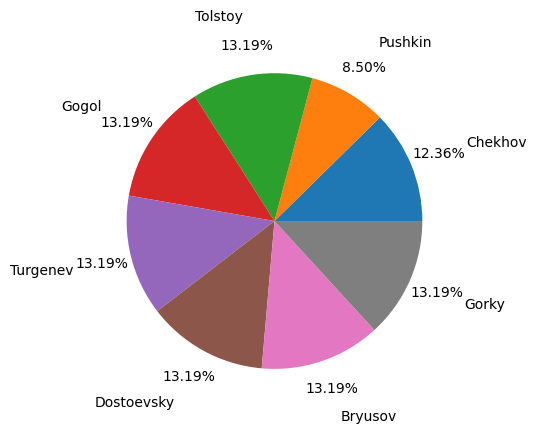

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 1979872 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Chekhov - 244769 слов, доля в общей базе: 12.36%
Pushkin - 168335 слов, доля в общей базе: 8.50%
Tolstoy - 261128 слов, доля в общей базе: 13.19%
Gogol - 261128 слов, доля в общей базе: 13.19%
Turgenev - 261128 слов, доля в общей базе: 13.19%
Dostoevsky - 261128 слов, доля в общей базе: 13.19%
Bryusov - 261128 слов, доля в общей базе: 13.19%
Gorky - 261128 слов, доля в общей базе: 13.19%
Среднее значение слов:  247484.0
Медианное значение слов:  261128.0


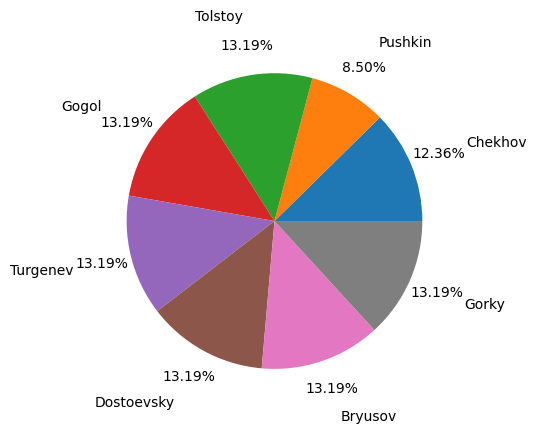

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

**Шаг 7. Нарезка примеров из текста методом скользящего окна**

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую выборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [ ]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (17745, 1000)
Форма выходных данных (меток) для обучающей выборки: (17745, 8)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1906, 1000)
Форма выходных данных (меток) для тестовой выборки: (1906, 8)


**Шаг 8. Определим вспомагательные функции**

In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: '+title)
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

Также определим функцию загрузки в модель весов Наташи для Embedding:

In [ ]:
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

### Сравнение архитектур сети

Так как мы используем предварительно сформированные векторные представления, то это накладывает ограничения на размерность входного слоя `Embedding` нашей модели (смотрим по имени файла navec_hudlit_v1_12B_500K_**300d**_100q.tar). Поэтому во всех наших экспериментах мы будем использовать один и тот же обученный входной слой `Embedding`.

#### **Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_1 = Sequential()

model_SimpleRNN_1.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_1.add(SpatialDropout1D(0.3))
# Слой нормализации данных
model_SimpleRNN_1.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_1.add(SimpleRNN(10))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_1.add(Dropout(0.3))
# Выходной слой классификатора
model_SimpleRNN_1.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_SimpleRNN_1 = loadEmbedding(model_SimpleRNN_1)

In [ ]:
model_SimpleRNN_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_SimpleRNN_1.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))


Epoch 1/50
139/139 [==============================] - 122s 840ms/step - loss: 2.3025 - accuracy: 0.1338 - val_loss: 2.1257 - val_accuracy: 0.1322
Epoch 2/50
139/139 [==============================] - 119s 858ms/step - loss: 2.1571 - accuracy: 0.1559 - val_loss: 2.0947 - val_accuracy: 0.1474
Epoch 3/50
139/139 [==============================] - 119s 860ms/step - loss: 2.0928 - accuracy: 0.1641 - val_loss: 2.0765 - val_accuracy: 0.1527
Epoch 4/50
139/139 [==============================] - 118s 852ms/step - loss: 2.0652 - accuracy: 0.1704 - val_loss: 2.0693 - val_accuracy: 0.1522
Epoch 5/50
139/139 [==============================] - 115s 821ms/step - loss: 2.0453 - accuracy: 0.1779 - val_loss: 2.0687 - val_accuracy: 0.1501
Epoch 6/50
139/139 [==============================] - 117s 841ms/step - loss: 2.0296 - accuracy: 0.1931 - val_loss: 2.0670 - val_accuracy: 0.1553
Epoch 7/50
139/139 [==============================] - 115s 829ms/step - loss: 2.0143 - accuracy: 0.1947 - val_loss: 2.0717 -

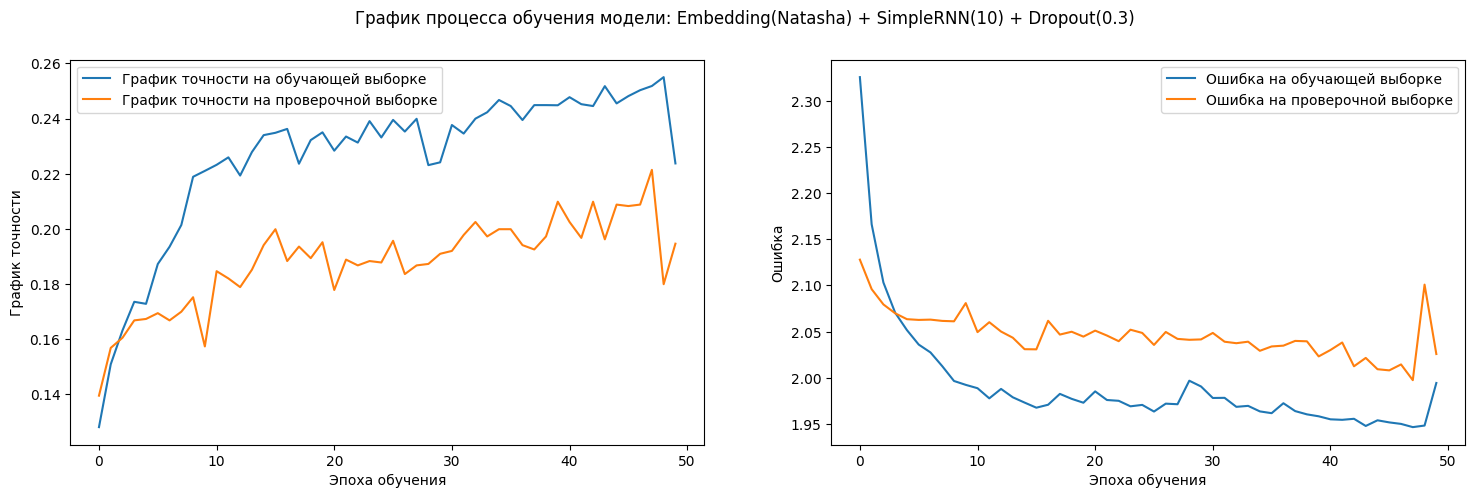

In [ ]:
show_plot(history, 'Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3)')

60/60 [==============================] - 5s 75ms/step


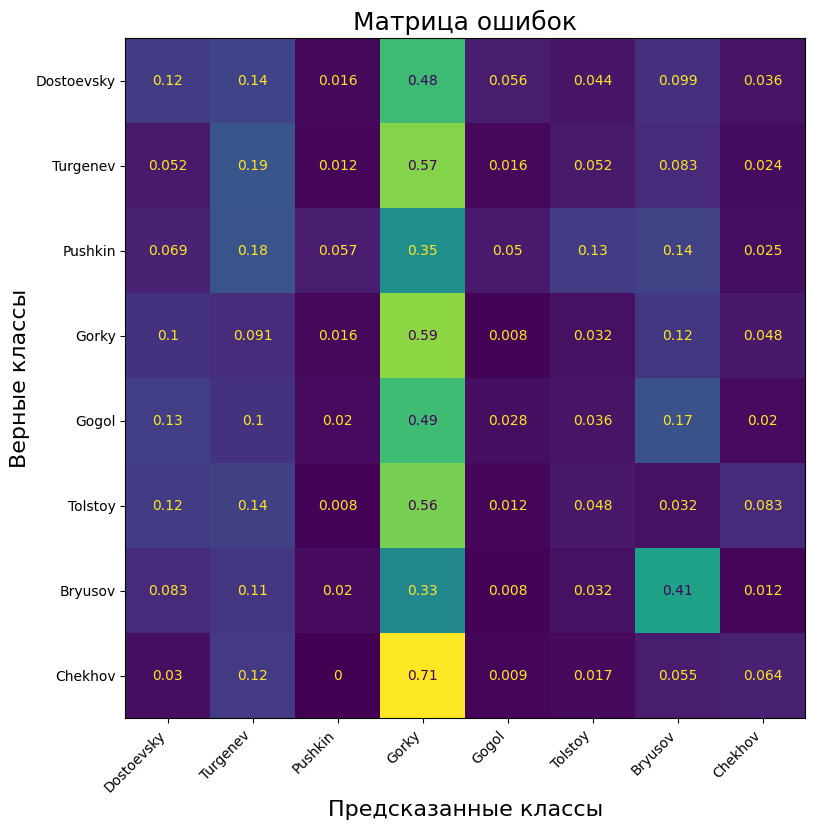


Средняя точность распознавания:  19%


In [ ]:
y_pred = model_SimpleRNN_1.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + SimpleRNN(5) + Dropout(0.2)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_2 = Sequential()

model_SimpleRNN_2.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_2.add(SpatialDropout1D(0.2))
# Слой нормализации данных
model_SimpleRNN_2.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_2.add(SimpleRNN(5))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_2.add(Dropout(0.2))
# Выходной слой классификатора
model_SimpleRNN_2.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_SimpleRNN_2 = loadEmbedding(model_SimpleRNN_2)

In [ ]:
model_SimpleRNN_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model_SimpleRNN_2.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 129s 887ms/step - loss: 2.2046 - accuracy: 0.1348 - val_loss: 2.1133 - val_accuracy: 0.1280
Epoch 2/50
139/139 [==============================] - 121s 873ms/step - loss: 2.1141 - accuracy: 0.1514 - val_loss: 2.0927 - val_accuracy: 0.1432
Epoch 3/50
139/139 [==============================] - 121s 872ms/step - loss: 2.0764 - accuracy: 0.1590 - val_loss: 2.0773 - val_accuracy: 0.1542
Epoch 4/50
139/139 [==============================] - 121s 867ms/step - loss: 2.0572 - accuracy: 0.1715 - val_loss: 2.0712 - val_accuracy: 0.1480
Epoch 5/50
139/139 [==============================] - 120s 861ms/step - loss: 2.0413 - accuracy: 0.1836 - val_loss: 2.0690 - val_accuracy: 0.1448
Epoch 6/50
139/139 [==============================] - 121s 864ms/step - loss: 2.0301 - accuracy: 0.1890 - val_loss: 2.0696 - val_accuracy: 0.1490
Epoch 7/50
139/139 [==============================] - 121s 869ms/step - loss: 2.0194 - accuracy: 0.1993 - val_loss: 2.0657 -

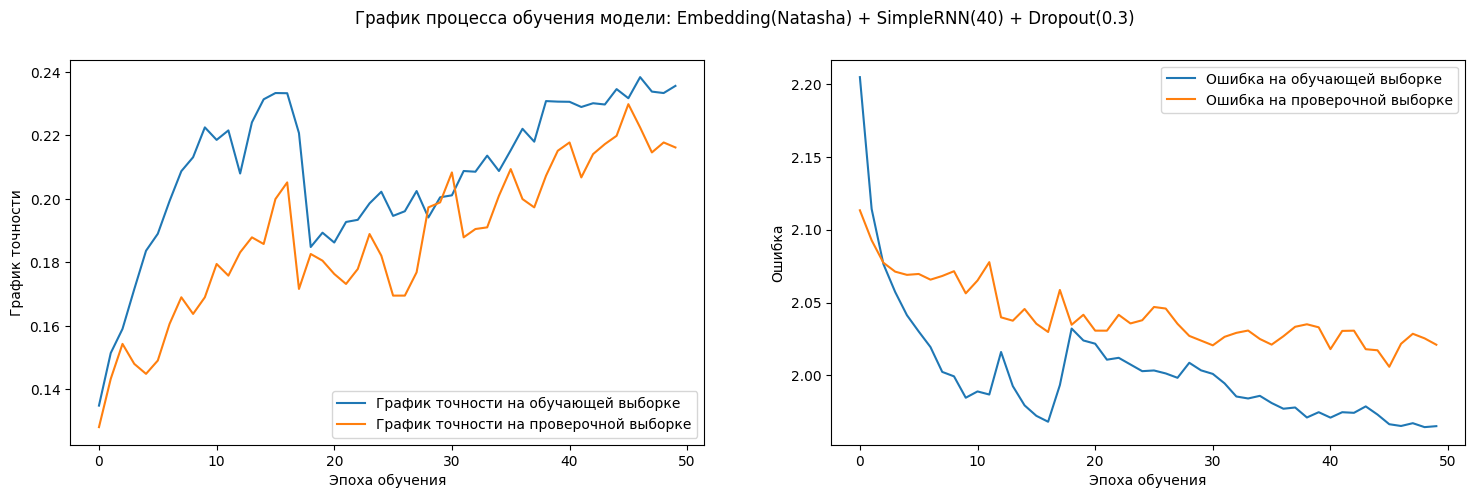

In [ ]:
show_plot(history2, 'Embedding(Natasha) + SimpleRNN(40) + Dropout(0.3)')

60/60 [==============================] - 5s 83ms/step


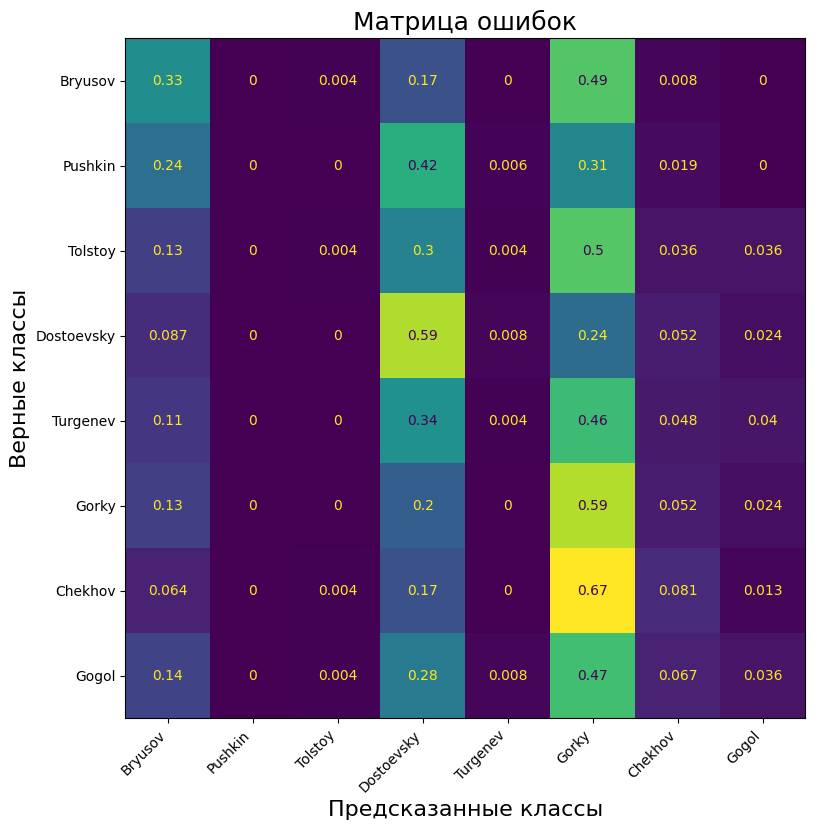


Средняя точность распознавания:  20%


In [ ]:
y_pred2 = model_SimpleRNN_2.predict(x_test)
show_confusion_matrix(y_test, y_pred2, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + GRU(10) + Dropout(0.2)**

Слой GRU в Keras с параметрами регуляризации не считается на cuda ядрах GPU процессора. При запуске на GPU увидите предупреждение. Поэтому расчеты будут производиться долго и придется запастись терпением.

In [ ]:
model_GRU_3 = Sequential()
model_GRU_3.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_GRU_3.add(SpatialDropout1D(0.2))
model_GRU_3.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_3.add(GRU(10, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model_GRU_3.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_GRU_3 = loadEmbedding(model_GRU_3)

In [ ]:
model_GRU_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model_GRU_3.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/20
139/139 [==============================] - 612s 4s/step - loss: 2.1553 - accuracy: 0.1387 - val_loss: 2.0626 - val_accuracy: 0.1474
Epoch 2/20
139/139 [==============================] - 610s 4s/step - loss: 2.0592 - accuracy: 0.1736 - val_loss: 2.0340 - val_accuracy: 0.1899
Epoch 3/20
139/139 [==============================] - 592s 4s/step - loss: 2.0174 - accuracy: 0.2041 - val_loss: 1.9855 - val_accuracy: 0.2282
Epoch 4/20
139/139 [==============================] - 600s 4s/step - loss: 1.8364 - accuracy: 0.3071 - val_loss: 1.5601 - val_accuracy: 0.4418
Epoch 5/20
139/139 [==============================] - 585s 4s/step - loss: 0.9744 - accuracy: 0.6582 - val_loss: 1.0372 - val_accuracy: 0.6354
Epoch 6/20
139/139 [==============================] - 590s 4s/step - loss: 0.5855 - accuracy: 0.8100 - val_loss: 1.0986 - val_accuracy: 0.6348
Epoch 7/20
139/139 [==============================] - 588s 4s/step - loss: 0.4394 - accuracy: 0.8587 - val_loss: 1.1979 - val_accuracy: 0.6259

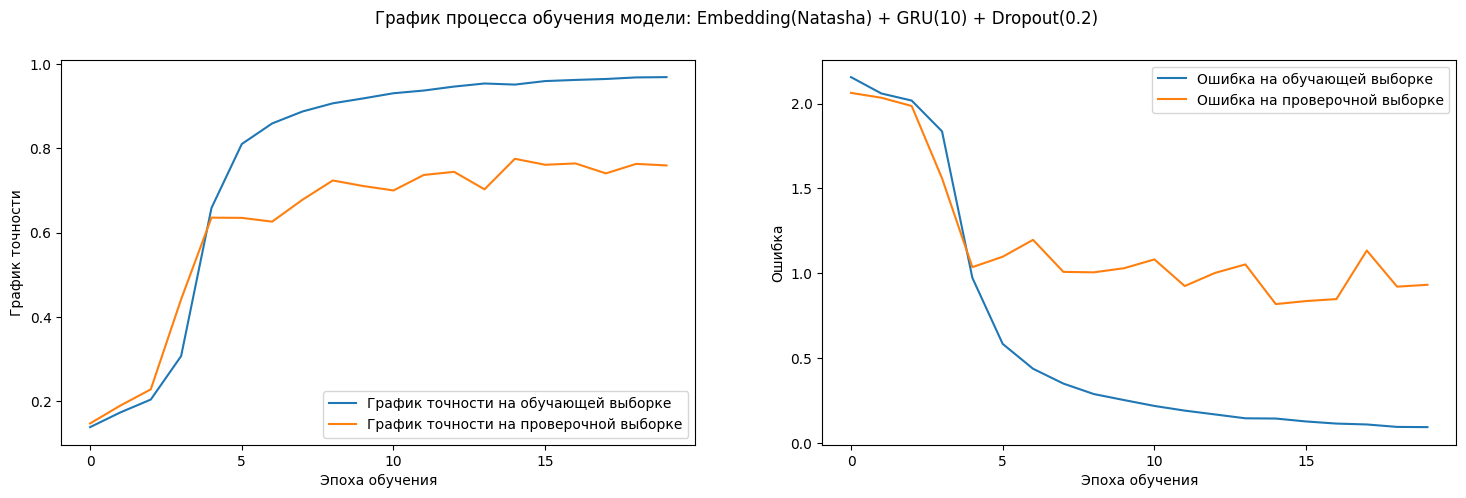

In [ ]:
show_plot(history3, 'Embedding(Natasha) + GRU(10) + Dropout(0.2)')

60/60 [==============================] - 12s 195ms/step


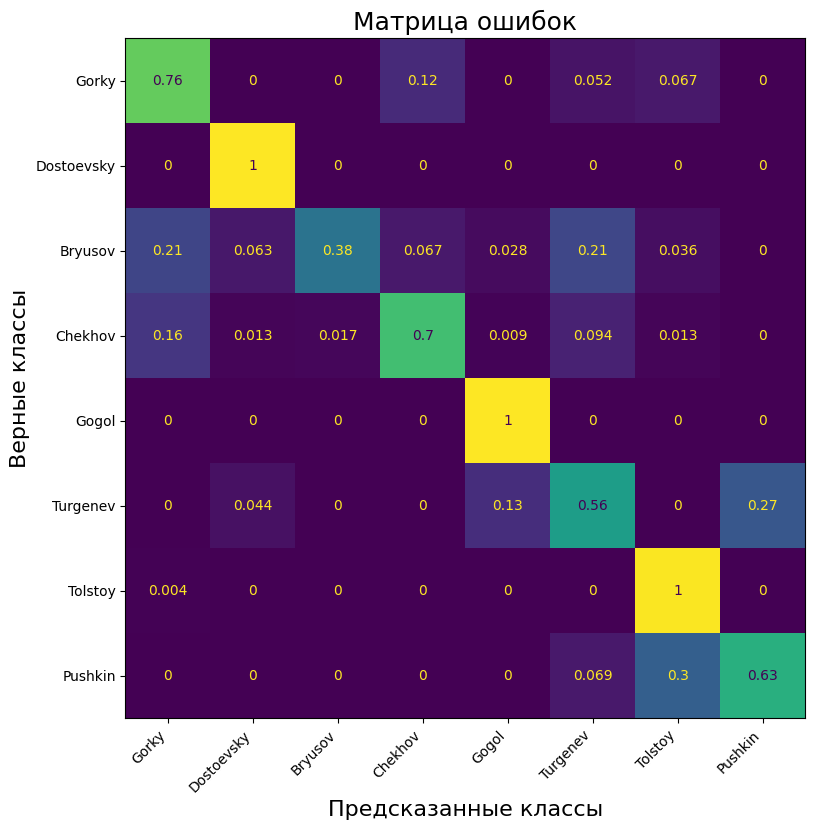


Средняя точность распознавания:  75%


In [ ]:
y_pred3 = model_GRU_3.predict(x_test)
show_confusion_matrix(y_test, y_pred3, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + GRU(40) + Dropout(0.2)**

In [ ]:
model_GRU_4 = Sequential()
model_GRU_4.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_GRU_4.add(SpatialDropout1D(0.2))
model_GRU_4.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_4.add(GRU(40, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model_GRU_4.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_GRU_4 = loadEmbedding(model_GRU_4)

In [ ]:
model_GRU_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model_GRU_4.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/20
139/139 [==============================] - 865s 6s/step - loss: 2.1180 - accuracy: 0.1664 - val_loss: 2.0230 - val_accuracy: 0.2067
Epoch 2/20
139/139 [==============================] - 878s 6s/step - loss: 1.7159 - accuracy: 0.3531 - val_loss: 1.1283 - val_accuracy: 0.6616
Epoch 3/20
139/139 [==============================] - 877s 6s/step - loss: 0.4891 - accuracy: 0.8364 - val_loss: 0.6735 - val_accuracy: 0.7655
Epoch 4/20
139/139 [==============================] - 868s 6s/step - loss: 0.1942 - accuracy: 0.9353 - val_loss: 0.5481 - val_accuracy: 0.8195
Epoch 5/20
139/139 [==============================] - 867s 6s/step - loss: 0.1168 - accuracy: 0.9617 - val_loss: 0.5530 - val_accuracy: 0.8263
Epoch 6/20
139/139 [==============================] - 870s 6s/step - loss: 0.0771 - accuracy: 0.9763 - val_loss: 0.5440 - val_accuracy: 0.8363
Epoch 7/20
139/139 [==============================] - 868s 6s/step - loss: 0.0526 - accuracy: 0.9835 - val_loss: 0.5585 - val_accuracy: 0.8395

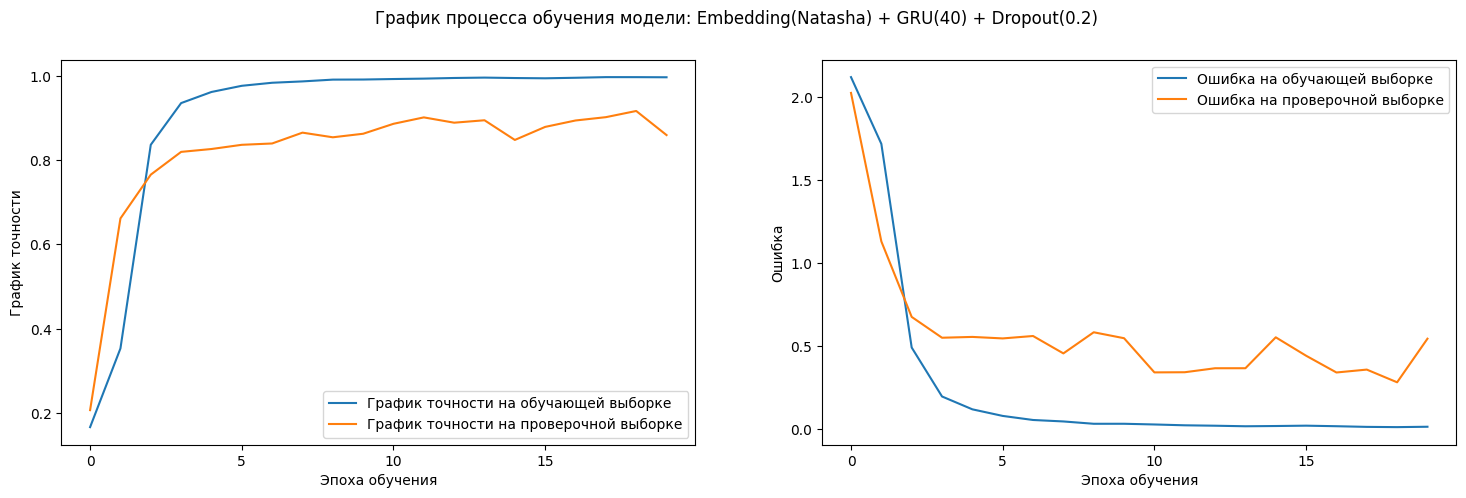

In [ ]:
show_plot(history4, 'Embedding(Natasha) + GRU(40) + Dropout(0.2)')

60/60 [==============================] - 13s 212ms/step


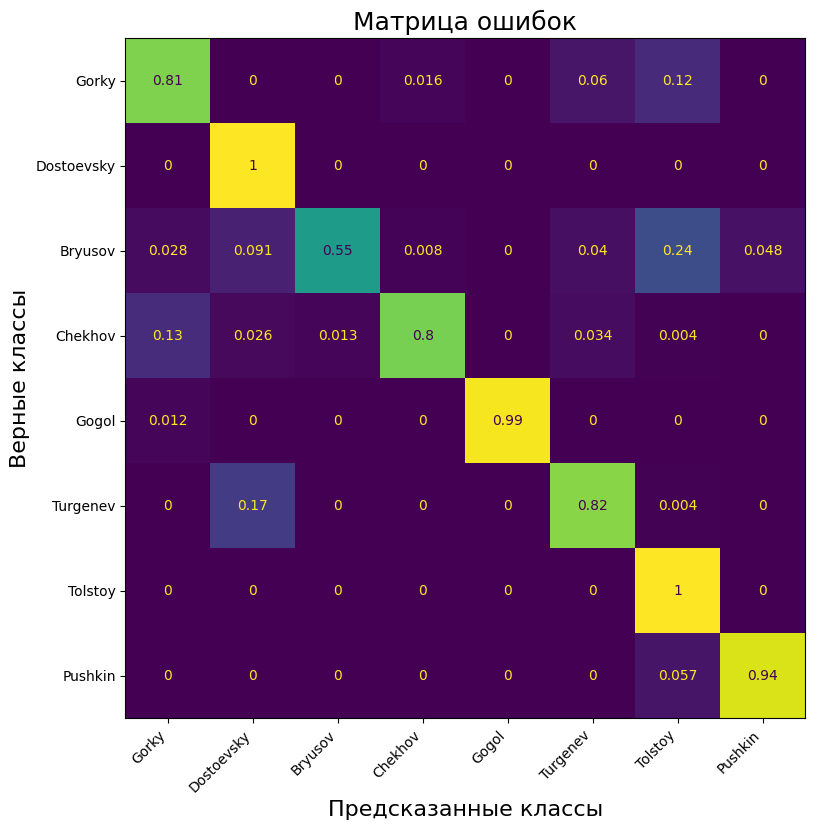


Средняя точность распознавания:  86%


In [ ]:
y_pred4 = model_GRU_4.predict(x_test)
show_confusion_matrix(y_test, y_pred4, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + LSTM(20) + Dropout(0.2)**

In [ ]:
model_LSTM_5 = Sequential()
model_LSTM_5.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_LSTM_5.add(SpatialDropout1D(0.2))
model_LSTM_5.add(BatchNormalization())

# Рекуррентный слой LSTM
model_LSTM_5.add(LSTM(20))
model_LSTM_5.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_LSTM_5 = loadEmbedding(model_LSTM_5)

In [ ]:
model_LSTM_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history5 = model_LSTM_5.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 10s 54ms/step - loss: 2.0167 - accuracy: 0.1999 - val_loss: 2.0044 - val_accuracy: 0.1936
Epoch 2/50
139/139 [==============================] - 7s 47ms/step - loss: 1.7877 - accuracy: 0.3344 - val_loss: 1.8982 - val_accuracy: 0.3075
Epoch 3/50
139/139 [==============================] - 7s 49ms/step - loss: 1.4700 - accuracy: 0.4808 - val_loss: 1.6636 - val_accuracy: 0.4292
Epoch 4/50
139/139 [==============================] - 6s 46ms/step - loss: 1.2817 - accuracy: 0.5548 - val_loss: 1.3227 - val_accuracy: 0.5205
Epoch 5/50
139/139 [==============================] - 7s 50ms/step - loss: 1.1398 - accuracy: 0.6008 - val_loss: 1.3107 - val_accuracy: 0.5582
Epoch 6/50
139/139 [==============================] - 6s 46ms/step - loss: 1.3709 - accuracy: 0.5152 - val_loss: 1.4240 - val_accuracy: 0.5152
Epoch 7/50
139/139 [==============================] - 7s 49ms/step - loss: 1.1266 - accuracy: 0.6074 - val_loss: 1.5084 - val_accuracy: 0.501

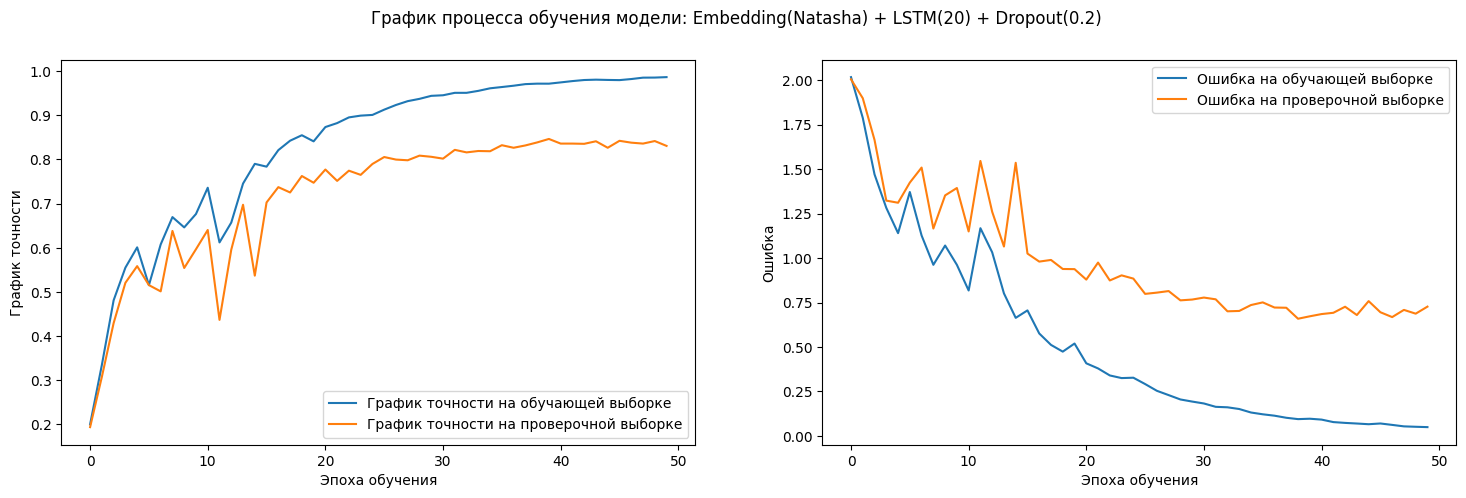

In [ ]:
show_plot(history5, 'Embedding(Natasha) + LSTM(20) + Dropout(0.2)')

60/60 [==============================] - 1s 14ms/step


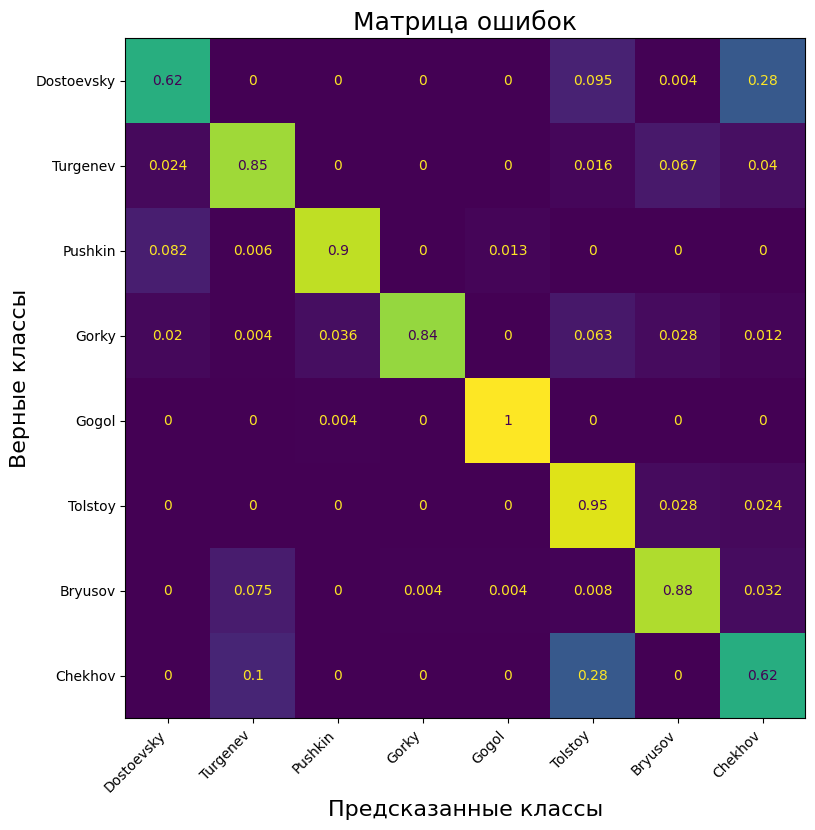


Средняя точность распознавания:  83%


In [ ]:
y_pred5 = model_LSTM_5.predict(x_test)
show_confusion_matrix(y_test, y_pred5, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + LSTM(100) + Dropout(0.3)**

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.3))
model_LSTM_6.add(BatchNormalization())

# Рекуррентный слой LSTM
model_LSTM_6.add(LSTM(100))
model_LSTM_6.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_LSTM_6 = loadEmbedding(model_LSTM_6)

In [ ]:
model_LSTM_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history6 = model_LSTM_6.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 15s 96ms/step - loss: 1.9309 - accuracy: 0.2464 - val_loss: 1.9731 - val_accuracy: 0.3148
Epoch 2/50
139/139 [==============================] - 14s 99ms/step - loss: 1.7100 - accuracy: 0.3820 - val_loss: 1.7870 - val_accuracy: 0.3416
Epoch 3/50
139/139 [==============================] - 14s 98ms/step - loss: 1.7065 - accuracy: 0.3788 - val_loss: 1.7110 - val_accuracy: 0.3841
Epoch 4/50
139/139 [==============================] - 13s 96ms/step - loss: 1.5298 - accuracy: 0.4610 - val_loss: 1.5679 - val_accuracy: 0.4344
Epoch 5/50
139/139 [==============================] - 13s 95ms/step - loss: 1.5810 - accuracy: 0.4436 - val_loss: 1.6815 - val_accuracy: 0.3966
Epoch 6/50
139/139 [==============================] - 13s 96ms/step - loss: 1.3418 - accuracy: 0.5494 - val_loss: 1.7710 - val_accuracy: 0.4213
Epoch 7/50
139/139 [==============================] - 14s 99ms/step - loss: 1.3816 - accuracy: 0.5207 - val_loss: 1.4828 - val_accuracy:

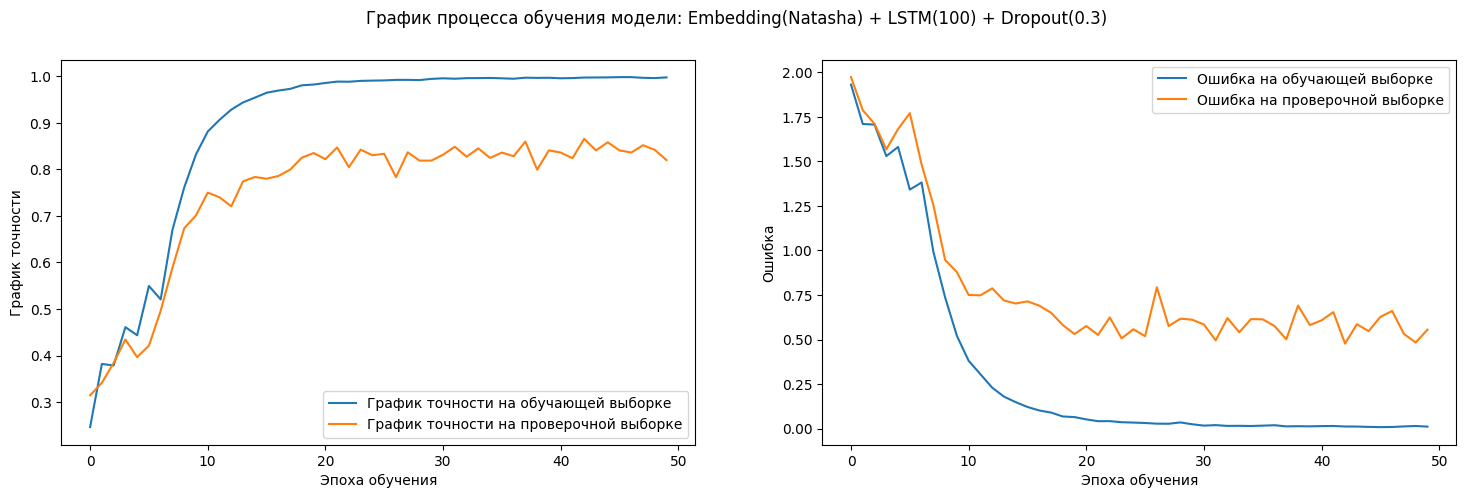

In [ ]:
show_plot(history6, 'Embedding(Natasha) + LSTM(100) + Dropout(0.3)')

60/60 [==============================] - 1s 16ms/step


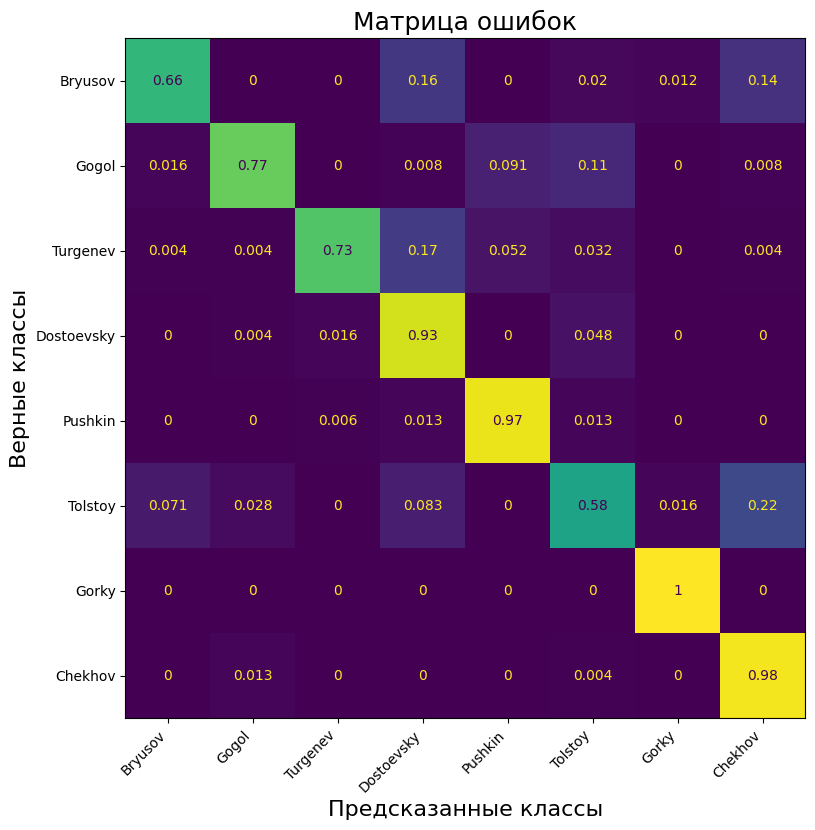


Средняя точность распознавания:  83%


In [ ]:
y_pred6 = model_LSTM_6.predict(x_test)
show_confusion_matrix(y_test, y_pred6, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)**

`Bidirectional(LSTM(8, return_sequences=True))` – этот слой
активизирует двунаправленную сеть **LSTM**;

`GRU(16, return_sequences=True, reset_after=True)` – параметр `reset_after=True` означает сброс данных.

In [ ]:
model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(16, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(100, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_MIX = loadEmbedding(model_MIX)

In [ ]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 40s 205ms/step - loss: 2.3619 - accuracy: 0.1393 - val_loss: 2.0766 - val_accuracy: 0.1359
Epoch 2/50
139/139 [==============================] - 25s 181ms/step - loss: 2.1287 - accuracy: 0.1794 - val_loss: 2.0446 - val_accuracy: 0.2004
Epoch 3/50
139/139 [==============================] - 25s 184ms/step - loss: 2.0026 - accuracy: 0.2267 - val_loss: 1.9965 - val_accuracy: 0.2566
Epoch 4/50
139/139 [==============================] - 26s 185ms/step - loss: 1.8282 - accuracy: 0.3216 - val_loss: 1.9133 - val_accuracy: 0.3478
Epoch 5/50
139/139 [==============================] - 26s 185ms/step - loss: 1.7276 - accuracy: 0.3663 - val_loss: 1.8524 - val_accuracy: 0.3715
Epoch 6/50
139/139 [==============================] - 25s 183ms/step - loss: 1.5570 - accuracy: 0.4374 - val_loss: 1.7434 - val_accuracy: 0.4423
Epoch 7/50
139/139 [==============================] - 26s 188ms/step - loss: 1.4392 - accuracy: 0.4839 - val_loss: 1.6279 - val_ac

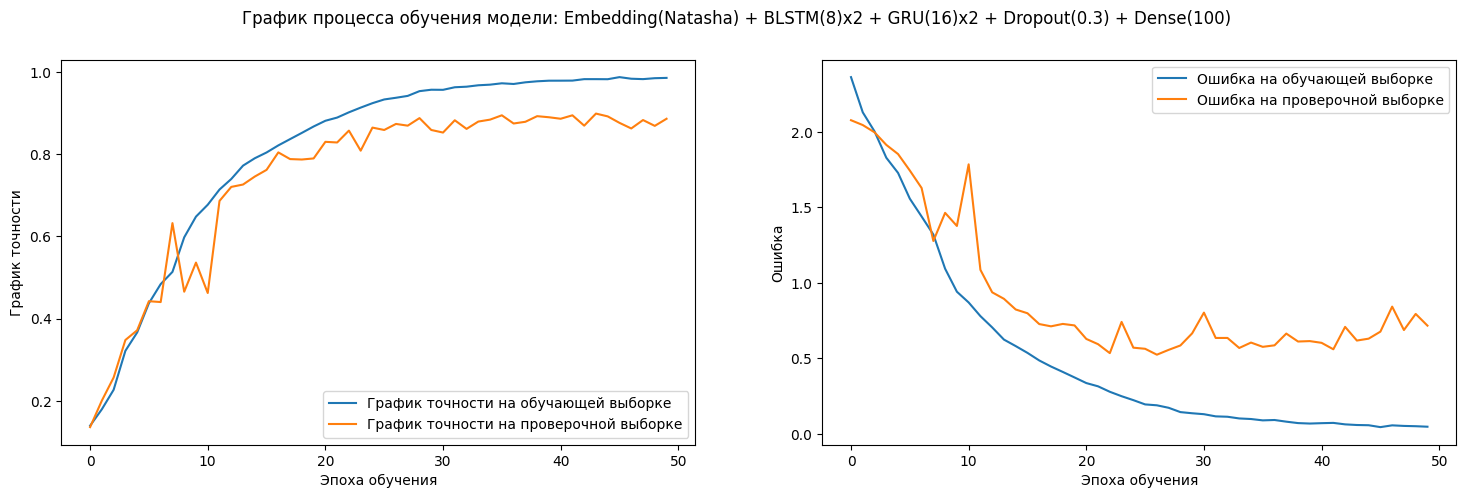

In [ ]:
show_plot(history_mix, 'Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)')

60/60 [==============================] - 7s 79ms/step


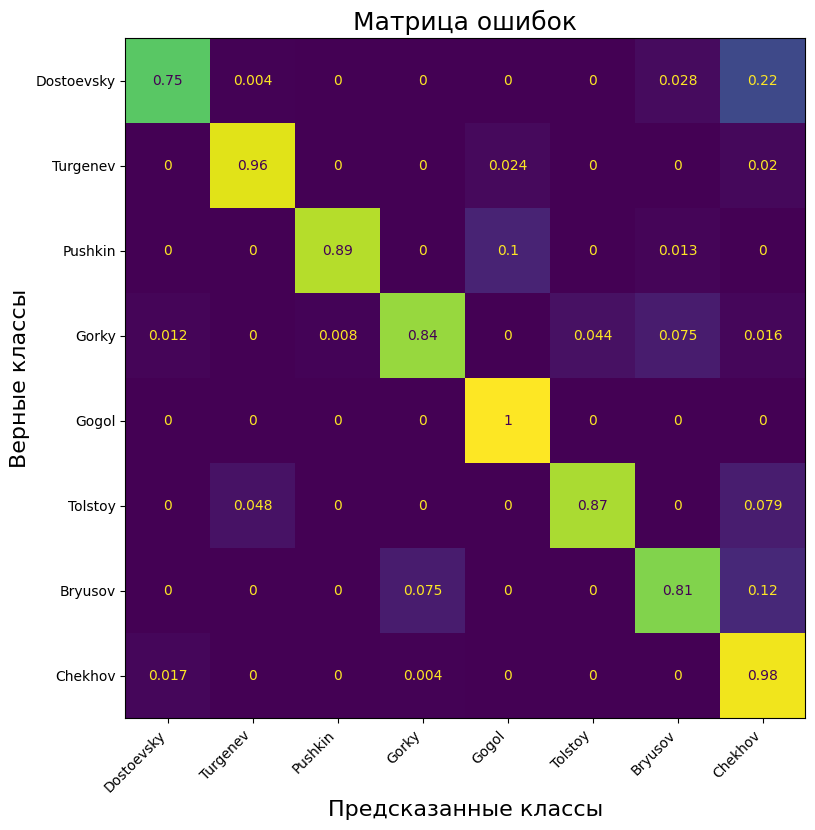


Средняя точность распознавания:  89%


In [ ]:
y_pred_mix = model_MIX.predict(x_test)
show_confusion_matrix(y_test, y_pred_mix, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2)**

In [ ]:
model_Conv1D = Sequential()
model_Conv1D.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_Conv1D.add(SpatialDropout1D(0.2))
model_Conv1D.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv1D.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv1D.add(MaxPooling1D(2))
model_Conv1D.add(Dropout(0.2))
# Слой пакетной нормализации
model_Conv1D.add(BatchNormalization())
# Слой выравнивания в вектор
model_Conv1D.add(Flatten())
model_Conv1D.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_Conv1D = loadEmbedding(model_Conv1D)

In [ ]:
model_Conv1D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_1D = model_Conv1D.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 14s 40ms/step - loss: 1.5092 - accuracy: 0.5096 - val_loss: 6.5058 - val_accuracy: 0.1327
Epoch 2/50
139/139 [==============================] - 5s 34ms/step - loss: 0.4495 - accuracy: 0.8438 - val_loss: 7.1744 - val_accuracy: 0.1663
Epoch 3/50
139/139 [==============================] - 5s 34ms/step - loss: 0.2064 - accuracy: 0.9281 - val_loss: 4.0421 - val_accuracy: 0.3599
Epoch 4/50
139/139 [==============================] - 5s 35ms/step - loss: 0.1149 - accuracy: 0.9614 - val_loss: 1.8543 - val_accuracy: 0.6254
Epoch 5/50
139/139 [==============================] - 5s 36ms/step - loss: 0.0723 - accuracy: 0.9767 - val_loss: 1.2098 - val_accuracy: 0.7466
Epoch 6/50
139/139 [==============================] - 5s 34ms/step - loss: 0.0529 - accuracy: 0.9830 - val_loss: 0.9605 - val_accuracy: 0.7886
Epoch 7/50
139/139 [==============================] - 5s 36ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.8956 - val_accuracy: 0.810

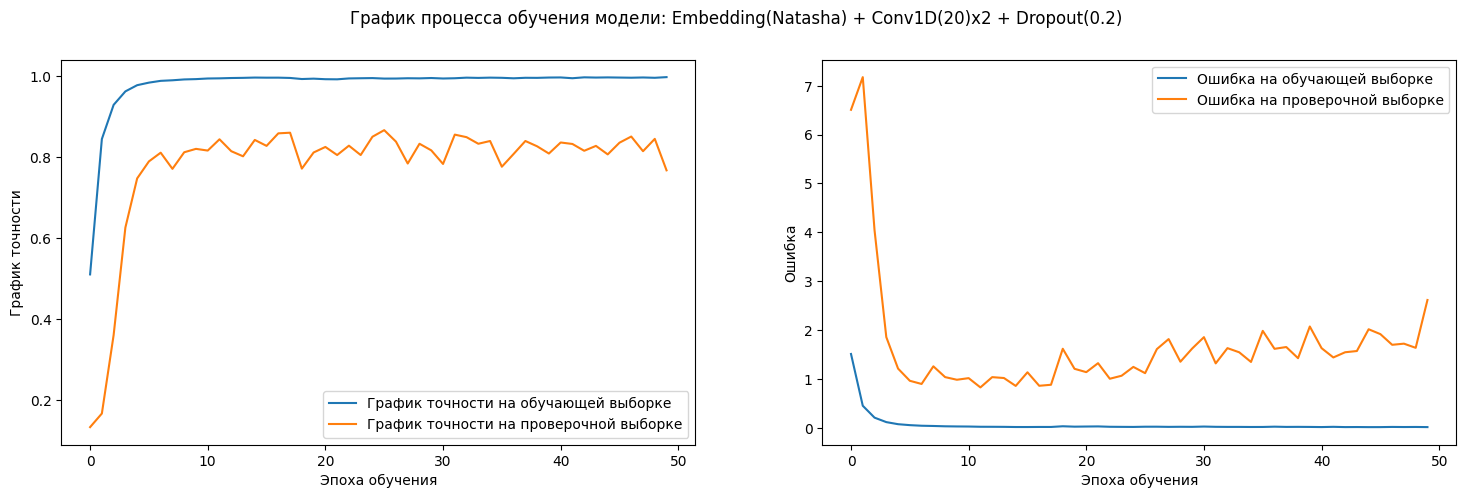

In [ ]:
show_plot(history_1D, 'Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2)')

60/60 [==============================] - 1s 5ms/step


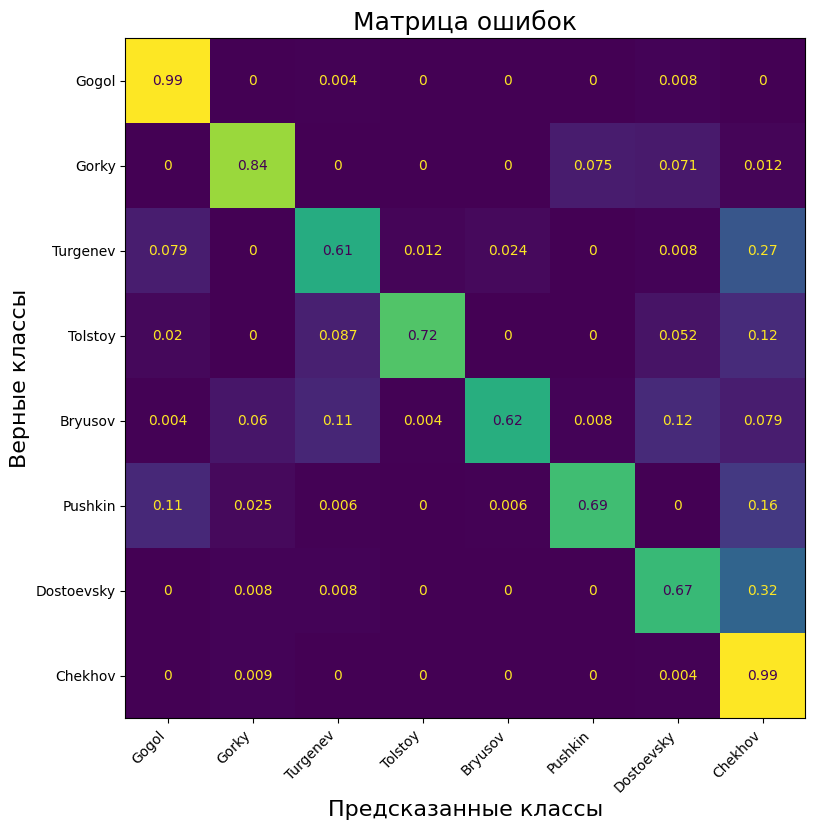


Средняя точность распознавания:  76%


In [ ]:
y_pred_1d = model_Conv1D.predict(x_test)
show_confusion_matrix(y_test, y_pred_1d, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + Conv1D(20)x3 + LSTM(4)x2 + Dropout(0.2) + Dense(100)**

In [ ]:
model_Conv_LSTM = Sequential()
model_Conv_LSTM.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_Conv_LSTM.add(SpatialDropout1D(0.2))
# Рекуррентный слой LSTM
model_Conv_LSTM.add(LSTM(4, return_sequences=1))
# Полносвязный слой
model_Conv_LSTM.add(Dense(100, activation='relu'))
# Сверточный слой
model_Conv_LSTM.add(Conv1D(20, 5, activation='relu'))
# Рекуррентный слой LSTM
model_Conv_LSTM.add(LSTM(4, return_sequences=1))
# Слой регуляризации Dropout
model_Conv_LSTM.add(Dropout(0.2))
# Слой пакетной нормализации
model_Conv_LSTM.add(BatchNormalization())
# Два сверточных слоя
model_Conv_LSTM.add(Conv1D(20, 5, activation='relu'))
model_Conv_LSTM.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_LSTM.add(MaxPooling1D(2))
model_Conv_LSTM.add(Dropout(0.2))
model_Conv_LSTM.add(BatchNormalization())
# Слой выравнивания в вектор
model_Conv_LSTM.add(Flatten())
model_Conv_LSTM.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_Conv_LSTM = loadEmbedding(model_Conv_LSTM)

In [ ]:
model_Conv_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_1D_LSTM = model_Conv_LSTM.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
139/139 [==============================] - 23s 98ms/step - loss: 2.2519 - accuracy: 0.2615 - val_loss: 2.9199 - val_accuracy: 0.1495
Epoch 2/50
139/139 [==============================] - 15s 109ms/step - loss: 1.3634 - accuracy: 0.5077 - val_loss: 8.4237 - val_accuracy: 0.0834
Epoch 3/50
139/139 [==============================] - 9s 67ms/step - loss: 0.8016 - accuracy: 0.7031 - val_loss: 4.0124 - val_accuracy: 0.2030
Epoch 4/50
139/139 [==============================] - 9s 66ms/step - loss: 0.5716 - accuracy: 0.7907 - val_loss: 3.7414 - val_accuracy: 0.1915
Epoch 5/50
139/139 [==============================] - 9s 66ms/step - loss: 0.4464 - accuracy: 0.8364 - val_loss: 1.5735 - val_accuracy: 0.5960
Epoch 6/50
139/139 [==============================] - 9s 64ms/step - loss: 0.3517 - accuracy: 0.8741 - val_loss: 1.4073 - val_accuracy: 0.7057
Epoch 7/50
139/139 [==============================] - 9s 67ms/step - loss: 0.2865 - accuracy: 0.8969 - val_loss: 1.2124 - val_accuracy: 0.7

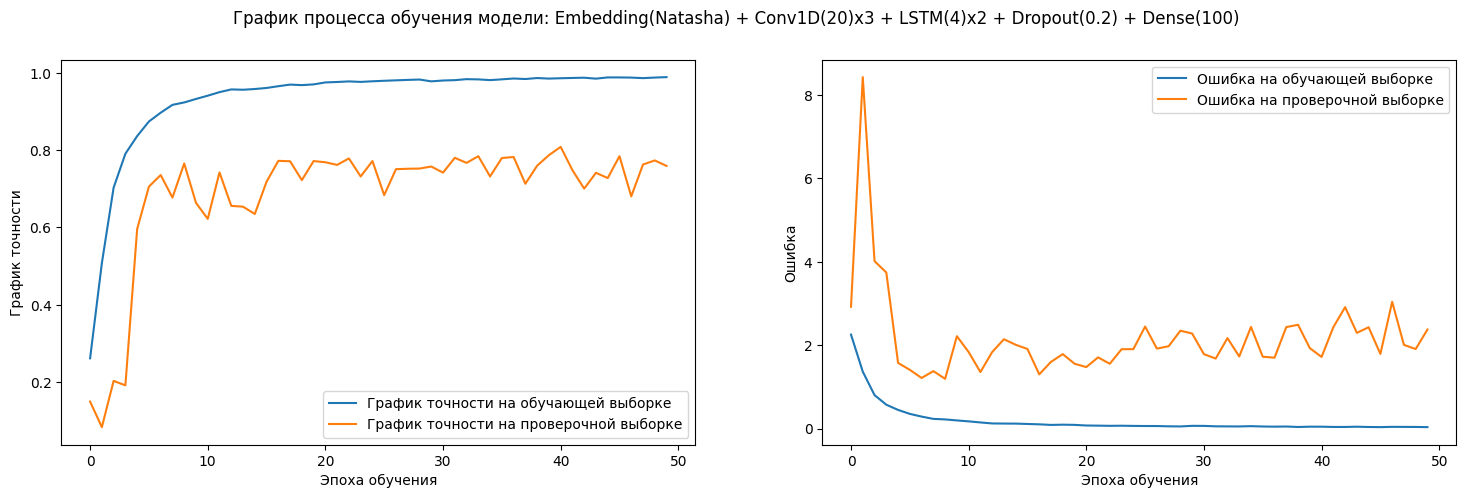

In [ ]:
show_plot(history_1D_LSTM, 'Embedding(Natasha) + Conv1D(20)x3 + LSTM(4)x2 + Dropout(0.2) + Dense(100)')

60/60 [==============================] - 3s 25ms/step


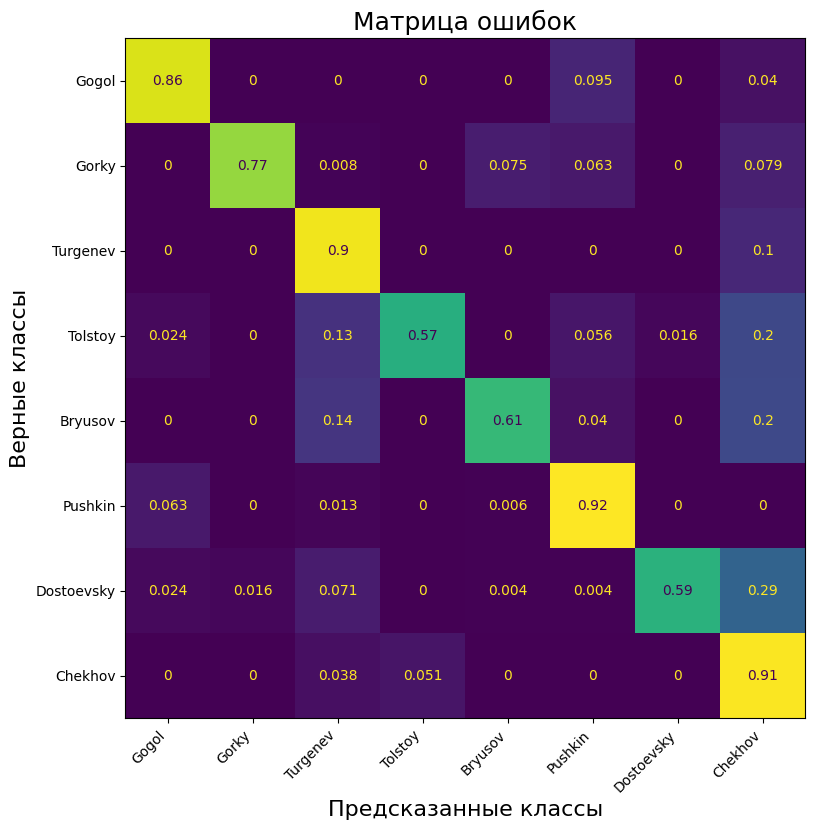


Средняя точность распознавания:  77%


In [ ]:
y_pred_lstm = model_Conv_LSTM.predict(x_test)
show_confusion_matrix(y_test, y_pred_lstm, CLASS_LIST_BALANCE)

#### Итоги

В данном эксперименте мы использовали одни и те же данные в качестве проверочных и тестовых данных. Мы это сделали нарочно, чтобы данные в матрице ошибки характеризовали наши итоговые данные на проверочной выборке. По ним мы и сравним наши архитектуры. А также для того, чтобы в домашней работе вы аккуратно и последовательно разделили выборки и сделали все по правилам: обучили на обучающей выборке, контролировали ход обучения по проверочной выборке, а итоговую матрицу ошибок построили по тестовой выборке.

Выпишем результаты средней точности распознования по матрице ошибок:
1. Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3) - **19%**
2. Embedding(Natasha) + SimpleRNN(5) + Dropout(0.2)  - **20%**
3. Embedding(Natasha) + GRU(10) + Dropout(0.2) - **75%**
4. Embedding(Natasha) + GRU(40) + Dropout(0.2) - **86%**
5. Embedding(Natasha) + LSTM(20) + Dropout(0.2) - **83%**
6. Embedding(Natasha) + LSTM(100) + Dropout(0.3) - **83%**
7. Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100) - **89%**
8. Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2) - **76%**
9. Embedding(Natasha) + Conv1D(20)x3 + LSTM(4)x2 + Dropout(0.2) + Dense(100) - **77%**

Как и следовало ожидать результаты на простых SimpleRNN (1 и 2 эксперименты) получились неудовлетворительными, поэтому по возможности не используйте их. Причина такого "скромного" результата заключается в исчезающем градиенте, о котором мы говорили ранее.

Вполне ожидаемо, что в нашем исследовании лучшей оказалась архитектура (7), использующая двухнаправленные LSTM сети в комбинации с GRU и полносвязанными сетями. Можете ее смело применять в своих проектах. Данная комбинация слоев была проверена на большом числе датасетов различных задач классификации текстов.  

Что неожиданно, но простая сверточная сеть (8 эксперимент), показала себя на уровне GRU (3 эксперимент)!

В целом по GRU, LSTM и одномерным сверткам результаты получились похожими и зависимыми от числа нейронов в слое.

Также вы можете самостоятельно проверить, что если мы не будем загружать в Эмбединги предварительно обученные веса из проекта Natasha, то потеряем по точности более 10%.

А теперь пора выполнить [домашнюю работу](https://colab.research.google.com/drive/1NMDG3ZeGgyHm0ei0DOC63PBb9rW6oN3O) с использованием наиболее понравившейся вам архитектурой, либо вы можете придумать свою.